### Text Classification Test

In [69]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from time import time
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix, f1_score
from statistics import mean
import pickle
from tensorflow import keras
from tensorflow.keras.models import load_model
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm as tq
import time
for i in tq(range(20), desc = 'tq() ### Library Importing Is Complete. ###'):
    time.sleep(0.5)

print('#####  IMPORTS COMPLETE  #####')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\proto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\proto\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\proto\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
tq() ### Library Importing Is Complete. ###: 100%|██████████| 20/20 [00:10<00:00,  1.97it/s]

#####  IMPORTS COMPLETE  #####


### Data Pre-Processing

In [53]:
dataset = fetch_20newsgroups(subset ='train', 
                             remove=('headers', 'footers', 'quotes'), 
                             shuffle=True, 
                             random_state=42)

df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target

label = []

for i in df['source']:
    label.append(dataset.target_names[i])

df['label']=label

# Remove source feature as label will be encoded for dependant:
df.drop(['source'], axis = 1, inplace = True)

# replace to politics
df['label'].replace({'talk.politics.misc':'politics','talk.politics.guns':'politics',
                     'talk.politics.mideast':'politics'}, inplace=True)
                    
# replace to sport
df['label'].replace({'rec.sport.hockey':'sport','rec.sport.baseball':'sport'}, inplace=True)
                    
# replace to religion
df['label'].replace({'soc.religion.christian':'religion','talk.religion.misc':'religion'}, inplace=True)
                    
# replace to computer
df['label'].replace({'comp.windows.x':'computer','comp.sys.ibm.pc.hardware':'computer',
                    'comp.os.ms-windows.misc':'computer','comp.graphics':'computer',
                    'comp.sys.mac.hardware':'computer'}, inplace=True)  
# replace to sales
df['label'].replace({'misc.forsale':'sales'}, inplace=True)

# replace to automobile
df['label'].replace({'rec.autos':'automobile','rec.motorcycles':'automobile'}, inplace=True)

# replace to science
df['label'].replace({'sci.crypt':'science','sci.electronics':'science','sci.space':'science'}, inplace=True)

# replace to medicine
df['label'].replace({'sci.med':'medicine'}, inplace=True)

# Apply word count on text data:
df['Number_of_words'] = df['text'].apply(lambda x:len(str(x).split()))

# Drop all words that equal 0:
no_text = df[df['Number_of_words']==0]

# drop these rows
df.drop(no_text.index,inplace=True)

# cleaning the text:

def clean_text(text):

    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to  datasets
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x))

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df['target']= label_encoder.fit_transform(df['label'])

In [54]:
# Drop features not needed:
df.reindex(columns = ['text','Number_of_words','cleaned_text','label','target'])
df.drop(['text','Number_of_words'], axis=1, inplace=True)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11014 entries, 0 to 11313
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label         11014 non-null  object
 1   cleaned_text  11014 non-null  object
 2   target        11014 non-null  int32 
dtypes: int32(1), object(2)
memory usage: 301.2+ KB


In [56]:
df.head(2)

,label,cleaned_text,target
0,automobile,i was wondering if anyone out there could enli...,1
1,computer,a fair number of brave souls who upgraded thei...,2


## Classifical Machine Learning Research & Development
- [Example](https://www.kaggle.com/rashmiek99/restaurant-review)
- [Pytorch-LSTM](https://www.kaggle.com/ludovicocuoghi/detecting-bullying-tweets-w-pytorch-bi-lstm)

#### Place holder for future NLP processing to test ML models.

In [59]:
# Dataframe and NLP processing for ML models:
# Copy dataframe for ML model R&D:
df_ml = df.copy()

# Tokenize Text:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# Removing Stopwords:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

# Lemmatization:
lem = WordNetLemmatizer()
def lem_word(x):
    return [lem.lemmatize(w) for w in x]

def combine_text(list_of_text):

    '''Takes a list of text and combines them into one large chunk of text.'''
    
    combined_text = ' '.join(list_of_text)
    return combined_text

# Apply NLP functions to dataframe:
df_ml['tokens'] = df_ml['cleaned_text'].apply(lambda x:tokenizer.tokenize(x))
df_ml['stopwordremove_tokens'] = df_ml['tokens'].apply(lambda x : remove_stopwords(x))
df_ml['lemmatized_text'] = df_ml['stopwordremove_tokens'].apply(lem_word)    
df_ml['final_text'] = df_ml['lemmatized_text'].apply(lambda x : combine_text(x))

In [63]:
# Drop features not needed:
df_ml.drop(['cleaned_text','tokens','stopwordremove_tokens','lemmatized_text'], axis=1, inplace=True)
df_ml.reindex(columns = ['label','final_text','target'])

,label,final_text,target
0,automobile,wondering anyone could enlighten car sawthe da...,1
1,computer,fair number brave soul upgraded si clock oscil...,2
2,computer,well folk mac plus finally gave ghost weekend ...,2
3,computer,weiteks addressphone number id like get inform...,2
4,science,article tombakerworldstdcom tom bakermy unders...,7
...,...,...,...
11309,medicine,dn nyedacnsvaxuwecedu david nyedn neurologydn ...,3
11310,computer,old mac mac plus problemtheir screen blank som...,2
11311,computer,installed cpu clone motherboard tried mounting...,2
11312,computer,wouldnt require hypersphere point specifiesa s...,2


In [64]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

cv = CountVectorizer(max_features= 2000)
X= cv.fit_transform(df_ml['final_text']).toarray()
y= df_ml['target']
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.25,stratify=y,random_state=4)

<AxesSubplot:xlabel='target', ylabel='count'>

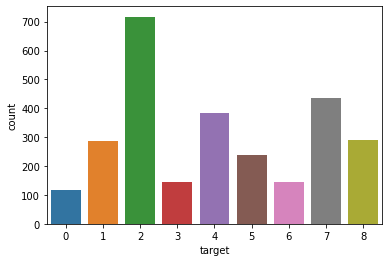

In [70]:
sns.countplot(y_test)

In [65]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

print("***RandomForest Classifier Model***")
rfc_model = RandomForestClassifier(n_estimators=1000,criterion='entropy')
rfc_model.fit(x_train,y_train)
y_pred = rfc_model.predict(x_test)
rfc_acc_score= accuracy_score(y_test,y_pred)
print("Accuracy Score:", round(rfc_acc_score * 100,2),"%")
print("Confusion Matrix")
rfc_cm = confusion_matrix(y_test, y_pred)
print(rfc_cm)

***RandomForest Classifier Model***
Accuracy Score: 65.94 %
Confusion Matrix
[[ 13   7  17   2  31  37   1   1   8]
 [  0 165  50   1  20   5  10  15  20]
 [  0  12 643   0  11   3  13  13  22]
 [  0   8  29  69  19   2   1  10   6]
 [  0  17  45   1 285   4   4  14  14]
 [  3   4  21   2  34 158   0   4  12]
 [  0   7  53   0   3   2  65   6   8]
 [  0  21 148   2  42   4   5 191  21]
 [  2  10  25   0  17   1   0   8 227]]


In [66]:
%%time
from sklearn.naive_bayes import GaussianNB

print("***Naive Bayes Model***")
gnb_model = GaussianNB()
gnb_model.fit(x_train,y_train)
y_pred = gnb_model.predict(x_test)
gnb_acc_score= accuracy_score(y_test,y_pred)
print("Accuracy Score:", round(gnb_acc_score * 100,2),"%")
print("Confusion Matrix")
gnb_cm = confusion_matrix(y_test, y_pred)
print(gnb_cm)

***Naive Bayes Model***
Accuracy Score: 45.32 %
Confusion Matrix
[[ 58   2   0   0  14  23  17   0   3]
 [ 23 117   9   5  11   5  84   7  25]
 [ 31  36 311  79   1   3 217  17  22]
 [ 27   5   3  63   9  11  15   8   3]
 [ 56  28   1  13 148  54  40  16  28]
 [ 73   2   3   5  27  97  15   1  15]
 [  3  11  23   7   5   2  84   5   4]
 [ 34  36  41  29   5  14  68 187  20]
 [ 25   6   0   6  17   1  48   4 183]]
Wall time: 832 ms
